1. INTRODUCTION

Hi, in this notebook, I'll create a  anime recommendation system 
We have the following available data

User ratings on animes
Information about the anime, like genre and type
We leverage both these informations to build our recommendation system. So lets get started!


In [1]:
# Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')


In [3]:
anime = pd.read_csv('anime.csv')
anime.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
df = pd.read_csv('rating.csv')
df.tail(5)

,user_id,anime_id,rating
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9
7813736,73516,8074,9


In [5]:
print('anime :', anime.shape)
print('rating :', df.shape)

anime : (12294, 7)
rating : (7813737, 3)


2. DATA PREPROCESSING
First, I'll merge the user rating dataframe with anime dataframe in order to get anime name

In [6]:
df = pd.merge(df,anime.drop('rating',axis=1), on='anime_id')

In [7]:
df.head(5)

,user_id,anime_id,rating,name,genre,type,episodes,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297


In [8]:
df.groupby('name')['rating'].mean().sort_values(ascending=False).head(10)

name
Shiroi Zou                                                          10.000000
Choegang Top Plate                                                  10.000000
Warui no wo Taose!! Salaryman Man                                   10.000000
STAR BEAT!: Hoshi no Kodou                                          10.000000
Doukyuusei                                                           9.000000
Yakushiji Ryouko no Kaiki Jikenbo: Hamachou, Voice &amp; Fiction     9.000000
Shiranpuri                                                           9.000000
Tang Lang Bu Chan                                                    9.000000
Steins;Gate 0                                                        8.500000
Kimi no Na wa.                                                       8.297863
Name: rating, dtype: float64

In [9]:
df.head(5)

,user_id,anime_id,rating,name,genre,type,episodes,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297


seems something's not right here. maybe that animes with 10 rating only got a few users watched them so the rating goes up so high.

so, we need another attribute in order to get better recommendation. number of users seems logical since the more users watched the anime, higher probability the anime gets the actual rating based on many users.

In [10]:
df.groupby('name')['rating'].count().sort_values(ascending=False).head(10)

name
Death Note                          39340
Sword Art Online                    30583
Shingeki no Kyojin                  29584
Code Geass: Hangyaku no Lelouch     27718
Elfen Lied                          27506
Angel Beats!                        27183
Naruto                              25925
Fullmetal Alchemist                 25032
Fullmetal Alchemist: Brotherhood    24574
Toradora!                           24283
Name: rating, dtype: int64

Now we see some popular anime here, like Shingeki No Kyojin, Naruto, and even Fullmetal Alchemist (I've watched all of them though, except Code Geass and Elfen Lied, maybe I should add them to my watchlist)

3 .EDA

In [11]:
df.columns

Index(['user_id', 'anime_id', 'rating', 'name', 'genre', 'type', 'episodes',
       'members'],
      dtype='object')

In [12]:
df.apply(lambda x: len(x.unique()))

user_id     73515
anime_id    11197
rating         11
name        11196
genre        3155
type            7
episodes      184
members      6487
dtype: int64

In [13]:
df.dtypes

user_id      int64
anime_id     int64
rating       int64
name        object
genre       object
type        object
episodes    object
members      int64
dtype: object

In [14]:
df.isnull().sum()

user_id       0
anime_id      0
rating        0
name          0
genre       110
type          4
episodes      0
members       0
dtype: int64

In [15]:
#deleting those rows which have null values...only in the column 'genre' and 'type' 
df.dropna(subset=['genre','type'],how='any',inplace=True)

In [16]:
df.shape

(7813613, 8)

In [17]:
df.isnull().sum()

user_id     0
anime_id    0
rating      0
name        0
genre       0
type        0
episodes    0
members     0
dtype: int64

Relation b/w name and rating

In [18]:
ratings = pd.DataFrame(df.groupby('name')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('name')['rating'].count())

genre_dict = pd.DataFrame(data=anime[['name','genre']])
genre_dict.set_index('name',inplace=True)
ratings.head()

,rating,num of ratings
name,,
&quot;0&quot;,2.769231,26
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.000000,2
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,5.774936,782
&quot;Bungaku Shoujo&quot; Memoire,6.155748,809
&quot;Bungaku Shoujo&quot; Movie,6.457980,1535


Now let's check anime number of ratings distribution

(0, 3000)

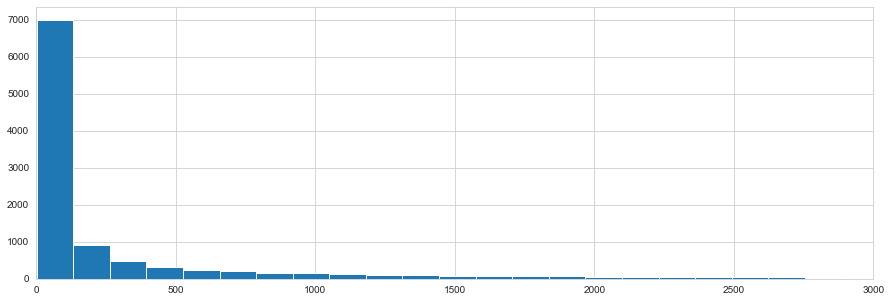

In [19]:
plt.figure(figsize=(15,5))
ratings['num of ratings'].hist(bins=300)
plt.xlim(0,3000)

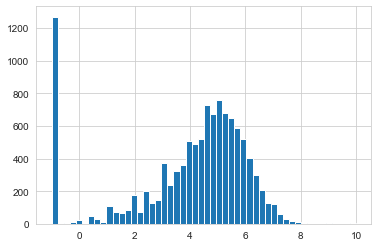

In [20]:
ratings['rating'].hist(bins=50)

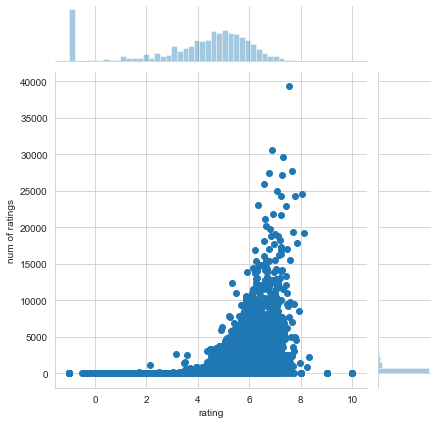

In [21]:
sns.jointplot(x='rating',y='num of ratings',data=ratings)

In [ ]:
From above scatterplot, we can see the higher number of users give rating, higher chance of the anime gets high rating too.

CORELATION MATRIX

In [22]:
corelation=df.corr()

In [23]:
corelation

,user_id,anime_id,rating,members
user_id,1.000000,-0.031639,0.002465,-0.015726
anime_id,-0.031639,1.000000,-0.005860,0.006616
rating,0.002465,-0.005860,1.000000,0.141311
members,-0.015726,0.006616,0.141311,1.000000


HEAT MAP

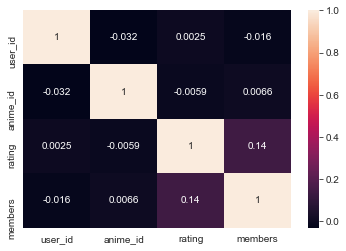

In [30]:
sns.heatmap(corelation,xticklabels=corelation.columns,yticklabels=corelation.columns,annot=True)

DISTRIBUTION PLOT

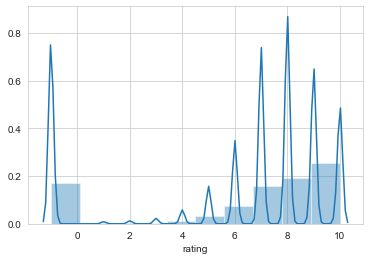

In [31]:
sns.distplot(df['rating'],bins=10)

In [33]:
df['type'].unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music'], dtype=object)

In [34]:
df['genre'].unique()

array(['Action, Comedy, Martial Arts, Shounen, Super Power',
       'Comedy, Romance, School, Shounen',
       'Comedy, Drama, Ecchi, Fantasy, Harem, Magic, Romance, School, Seinen',
       ..., 'Action, Comedy, Historical, Samurai', 'Kids, Mecha',
       'Action, Historical, Kids'], dtype=object)

4. FUNCTION CREATION

Now I'll create the function to be executed when a user accessing an anime page on myanimelist, so that user can get the recommendation based on that anime. This recommendation will be generated based on ratings and genre

In [21]:
def check_genre(genre_list,string):
    if any(x in string for x in genre_list):
        return True
    else:
        return False
    
def get_recommendation(name):
    #generating list of anime with the same genre with target
    anime_genre = genre_dict.loc[name].values[0].split(', ')
    cols = anime[anime['genre'].apply(
        lambda x: check_genre(anime_genre,str(x)))]['name'].tolist()
    
    #create matrix based on generated list
    animemat = df[df['name'].isin(cols)].pivot_table(
        index='user_id',columns='name',values='rating')
       
    #create correlation table
    anime_user_rating = animemat[name]
    similiar_anime = animemat.corrwith(anime_user_rating)
    corr_anime = pd.DataFrame(similiar_anime,columns=['correlation'])
    corr_anime = corr_anime.join(ratings['num of ratings'])
    corr_anime.dropna(inplace=True)
    corr_anime = corr_anime[corr_anime['num of ratings']>5000].sort_values(
        'correlation',ascending=False)
    
    return corr_anime.head(10)

5. TESTING

In [ ]:
get_recommendation('Shingeki no Kyojin')

In [ ]:
get_recommendation('Kimi no Na wa.')